In [35]:
from sklearn.metrics import accuracy_score, classification_report , confusion_matrix , ConfusionMatrixDisplay
from tensorflow.keras.applications.efficientnet_v2 import EfficientNetV2B2
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense,Flatten
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import Model
from sklearn.model_selection import train_test_split
from keras.models import load_model
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import pickle as pkl
import pandas as pd

In [36]:
tf. __version__

'2.10.0'

In [3]:
model_name = 'EfficientNetV2B3_2'

In [4]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


<h1>Loading Dataset and images</h1>

In [5]:
train_df = pd.read_csv('./train.csv',index_col='id')
test_df = pd.read_csv('./test.csv',index_col='id')

In [6]:
train_df['label'] = train_df['label'].astype(str)

In [7]:
datagen=ImageDataGenerator(rescale=1./255,validation_split=0.10,rotation_range=20,  # Random rotation
                             width_shift_range=0.2,  # Random horizontal shift
                             height_shift_range=0.2,  # Random vertical shift
                             shear_range=0.2,  # Random shear
                             horizontal_flip=True)

In [8]:
train_generator = datagen.flow_from_directory(
    directory="./imageset/train/",
    batch_size=32,
    seed=42,
    shuffle=True,
    class_mode="sparse",
    target_size=(224, 224),
    subset="training"
)
validation_generator = datagen.flow_from_directory(
    directory="./imageset/train/",
    batch_size=32,
    seed=42,
    shuffle=False,
    class_mode="sparse",
    target_size=(224, 224),
    subset="validation"  # Specify that this is the validation set
)

Found 8525 images belonging to 10 classes.
Found 944 images belonging to 10 classes.


<h1>Model Architecture</h1>

In [21]:
def load_model_1(input_shape=(224,224,3),lr=0.001,classes=10):
    base_model = EfficientNetV2B2(include_top=False, weights='imagenet', input_shape=input_shape)
    x = base_model.output
    x = Flatten()(x)
    x = Dense(128, activation='relu')(x)
    # x = Dense(64, activation='relu')(x)
    output = Dense(classes, activation='softmax')(x)
    # this is the model we will train
    model = Model(inputs=base_model.input, outputs=output)
    model.compile(optimizer=tf.keras.optimizers.Adam(lr=lr), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model
    

In [24]:
model = load_model_1(input_shape=train_generator.image_shape,lr=0.0001)

c:\Users\Hazim\anaconda3\envs\tf\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [25]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling (Rescaling)          (None, 224, 224, 3)  0           ['input_1[0][0]']                
                                                                                                  
 normalization (Normalization)  (None, 224, 224, 3)  0           ['rescaling[0][0]']              
                                                                                                  
 stem_conv (Conv2D)             (None, 112, 112, 32  864         ['normalization[0][0]']      

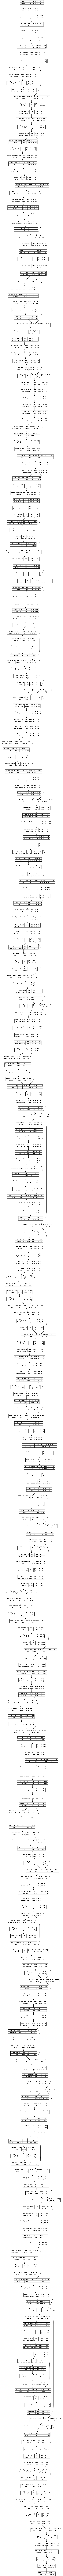

In [26]:
plot_model(model,show_shapes=True, show_layer_names=True)

In [27]:
# Define the checkpoint path and early stopping
checkpoint_path = f"model_checkpoint_class_{model_name}.h5"
checkpoint = ModelCheckpoint(checkpoint_path, save_best_only=True,monitor='val_accuracy',mode='max')
early_stopping = EarlyStopping(monitor='val_accuracy', patience=10, verbose=1)
# Loads the weights
# model.load_weights(checkpoint_path)

In [28]:
history = model.fit(train_generator,steps_per_epoch=len(train_generator),
                    epochs=100,
                    validation_data=validation_generator,
                    validation_steps=len(validation_generator),
                    verbose=1,
                    callbacks=[checkpoint,early_stopping])

Epoch 1/100
267/267 [==============================] - 154s 505ms/step - loss: 0.6234 - accuracy: 0.8023 - val_loss: 1.1121 - val_accuracy: 0.6631
Epoch 2/100
267/267 [==============================] - 131s 489ms/step - loss: 0.2108 - accuracy: 0.9357 - val_loss: 1.1373 - val_accuracy: 0.6451
Epoch 3/100
267/267 [==============================] - 138s 517ms/step - loss: 0.1348 - accuracy: 0.9587 - val_loss: 0.2871 - val_accuracy: 0.9174
Epoch 4/100
267/267 [==============================] - 133s 497ms/step - loss: 0.1089 - accuracy: 0.9675 - val_loss: 0.2001 - val_accuracy: 0.9534
Epoch 5/100
267/267 [==============================] - 127s 475ms/step - loss: 0.0846 - accuracy: 0.9737 - val_loss: 0.4046 - val_accuracy: 0.8930
Epoch 6/100
267/267 [==============================] - 128s 480ms/step - loss: 0.0757 - accuracy: 0.9747 - val_loss: 0.1895 - val_accuracy: 0.9566
Epoch 7/100
267/267 [==============================] - 129s 481ms/step - loss: 0.0753 - accuracy: 0.9777 - val_loss: 1

KeyboardInterrupt: 

In [29]:
model.load_weights(checkpoint_path)

In [ ]:
def plot_history(history,metrics):
    plt.plot(history.history[metrics])
    plt.plot(history.history['val_'+metrics])
    plt.title(f'model {metrics}')
    plt.ylabel(f'{metrics}') 
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()

In [ ]:
plot_history(history,metrics='accuracy')

In [ ]:
plot_history(history,metrics='loss')

In [30]:
STEP_SIZE_VALID=validation_generator.n//validation_generator.batch_size+1
model.evaluate(validation_generator,
steps=STEP_SIZE_VALID)

30/30 [==============================] - 22s 714ms/step - loss: 0.1554 - accuracy: 0.9661


[0.15535354614257812, 0.9661017060279846]

In [31]:
# Get true labels for validation set
STEP_SIZE_TEST=validation_generator.n//validation_generator.batch_size+1
validation_generator.reset()
y_pred=model.predict(validation_generator,
steps=STEP_SIZE_TEST,
verbose=1)
y_pred_classes = np.argmax(y_pred, axis=1)  # Convert predictions to class labels
y_true = validation_generator.classes


# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)

30/30 [==============================] - 26s 731ms/step


In [ ]:
np.unique(y_pred_classes)

Accuracy: 0.961864406779661
Classwise Classification Report: 
              precision    recall  f1-score   support

           0       1.00      0.98      0.99        96
           1       0.99      0.95      0.97        95
           2       0.97      0.96      0.96        96
           3       0.93      0.97      0.95        99
           4       0.93      0.93      0.93        85
           5       0.94      0.97      0.95        94
           6       0.94      0.99      0.96        95
           7       0.99      0.99      0.99        96
           8       0.97      0.94      0.95        93
           9       0.97      0.95      0.96        95

    accuracy                           0.96       944
   macro avg       0.96      0.96      0.96       944
weighted avg       0.96      0.96      0.96       944


Confusion Matrix: 


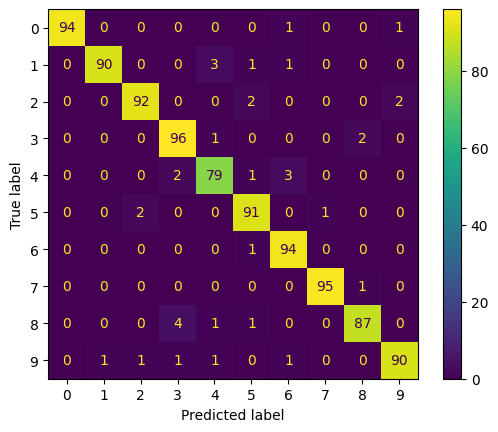

In [32]:
print(f"Accuracy: {accuracy_score(y_true, y_pred_classes)}")
print(f"Classwise Classification Report: \n{classification_report(y_true, y_pred_classes)}")
con_matrix = confusion_matrix(np.ravel(y_true), y_pred_classes)
print("\nConfusion Matrix: ")
con_matrix = ConfusionMatrixDisplay(con_matrix)
con_matrix.plot()
plt.show()

In [33]:
model.save(f'./Models/{model_name}_custom.h5')

In [ ]:
# Load the model from the file
model = load_model(f"./Models/{model_name}_custom.h5")